# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

# Exercise Solution

Choosen first possibility, so i parallelized my code with *continent* solution.

As metric was used the euclidean distance, as using this formula:

$$
    D = \sum_{i=0}^{N} \sqrt{\left(x[i + 1] - x[i]\right)^2 + \left(y[i + 1] - y[i]\right)^2}
$$

Where $N$ identifies the number of cities, in this context Periodic Boundary Conditions (PBC) where applyed, and those are denoted by `[]` operator, so that $N+1=0$.
Another metric that could be used is the Greater Circle Distance, this can be certainly better, because due to size of Italy (lenght = 1200 km, [source](https://it.wikipedia.org/wiki/Geografia_dell%27Italia#Punti_estremi)), this is comparable to Earth Radius (6370 km, [source](https://en.wikipedia.org/wiki/Earth_radius)),
but in this context was not deemed necessary.
In the code a distance matrix was calculated by the first process (rank = 0) and then communicated to other processes, to reduce the number of calculation during optimization phase. For this purpose [Armadillo Library](https://arma.sourceforge.net/) was used.

The subsequent char used was taken from [ISTAT Archive](https://www.istat.it/it/archivio/222527).

It was used the migration strategy proposed.

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import geopandas
import contextily as cx
import xyzservices.providers as xyz
from pathlib import Path
from dataclasses import dataclass, asdict 
import json
from subprocess import run
from shutil import copy

plt.style.use('seaborn-v0_8')

In [3]:
@dataclass
class Config:
    number_of_generations: int = 70
    population_size: int =  5000
    number_of_contacts: int =  5
    n_transfer_elements: int =  500
    initial_shuffling: int =  300
    selection_coeff: float =  3
    crossover_probability: float = 0.6
    swap_probability: float = 0.06
    permutate_probability: float = 0.07
    inverse_probability: float = 0.07
    shift_probability: float = 0.06

def save_config(config: Config, path: Path) -> None:
    with path.open('w') as f:
        json.dump(asdict(config), f, indent=4)  

def execute(nr_of_processes : int = 4, exec_type : str = 'multi_thread') -> None:
    execution_dir = Path('eser_10/10_1')
    result_dir = Path('eser_10/output')
    
    output_dir = Path(f'eser_10/results/{exec_type}')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    #Removing old files if they exist
    for file in output_dir.glob('*.csv'):
        file.unlink()
    
    # Execution
    cmd = f"mpiexec -n {nr_of_processes} --oversubscribe ./main_10_1.exe".split()
    run(cmd, cwd=execution_dir)
    
    # Saving results
    for file  in result_dir.iterdir():
        copy(file, output_dir)


config_path = Path('eser_10/10_1/input.json')

3


/tmp/ipykernel_2648/3864500511.py:9: RuntimeWarning: divide by zero encountered in power
  axs[0].plot( x , (lambda x : 1/coeff * np.power(x, -1 + 1/coeff))(x), label='PDF(X)')


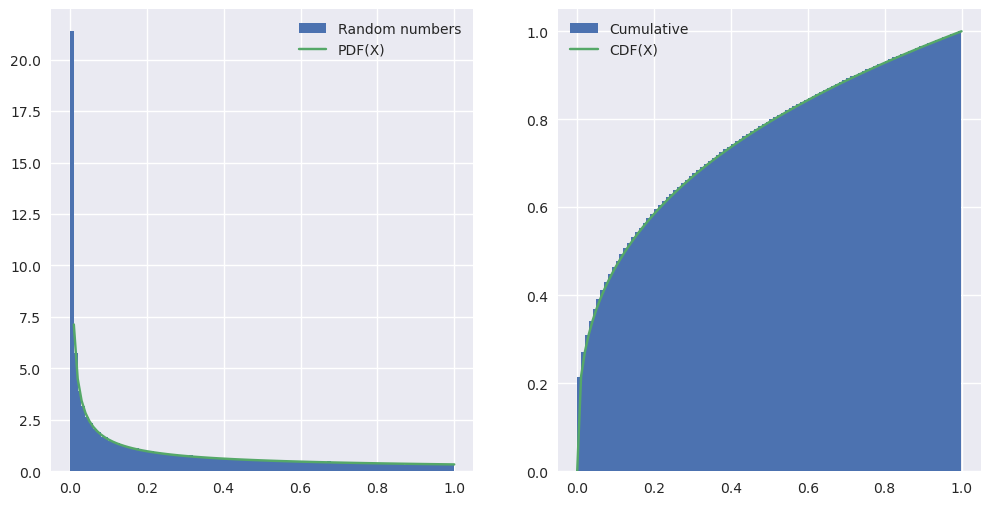

In [309]:
coeff = Config().selection_coeff
pop_size = 1 #Config().population_size
print(coeff)
rng = np.random.default_rng()
x = np.linspace(0, 1, 100)
random_numbers = pop_size * rng.random(100000) ** coeff
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(random_numbers, bins=100, label='Random numbers', density=True)
axs[0].plot( x , (lambda x : 1/coeff * np.power(x, -1 + 1/coeff))(x), label='PDF(X)')
axs[1].hist(random_numbers, bins=100, label='Cumulative', cumulative=True, density=True)
axs[1].plot(x, (lambda x : np.power(x, 1/coeff))(x), label='CDF(X)')
for ax in axs:
    ax.legend()

The graph above show the selection operator used to choose which individuals use to generate the next generation. It was choosen to have the first half of the population extracted with an 80% probability.

In [310]:
nr_of_processes = 6
config = Config()
# config.n_transfer_elements = 5
save_config(config, config_path)
execute(nr_of_processes=nr_of_processes)
config.n_transfer_elements = 0
save_config(config, config_path)
execute(nr_of_processes=nr_of_processes, exec_type='indipendent_thread')

Hello World!!
I am rank 0 of 6
on CPU : Anthrax
Rank 0 => Population Size is 5000
Rank 0 => Number of generation to evolve : 70
Rank 0 => Number of contacts between continents : 5
Rank 0 => Number of elements to transfer for continent : 500
Rank 0 => Number of shuffle to generate population : 300
Rank 0 => Selection Coefficent : 3.00
Rank 0 => Probability of crossover : 60.00
Rank 0 => Probability of swap : 6.00
Rank 0 => Probability of permutation : 7.00
Rank 0 => Probability of Inversion : 7.00
Rank 0 => Probability of shift : 6.00
Hello World!!
I am rank 1 of 6
on CPU : Anthrax
Rank 1 => Population Size is 5000
Rank 1 => Number of generation to evolve : 70
Rank 1 => Number of contacts between continents : 5
Rank 1 => Number of elements to transfer for continent : 500
Rank 1 => Number of shuffle to generate population : 300
Rank 1 => Selection Coefficent : 3.00
Rank 1 => Probability of crossover : 60.00
Rank 1 => Probability of swap : 6.00
Rank 1 => Probability of permutation : 7.00


In [4]:
italy: geopandas.GeoDataFrame = geopandas.read_file(
    "eser_10/charts/ProvCM01012024_g_WGS84.shp"
).to_crs('EPSG:4326')
data = pd.read_csv("eser_10/results/multi_thread/best_route.csv")
data.loc[data.shape[0]] = data.iloc[0]
data


,INDEX,PROVINCE,LONGITUDE,LATITUDE
0,0,Agrigento,13.57470,37.3123
1,65,Palermo,13.35240,38.1112
2,97,Trapani,12.51600,38.0174
3,96,Ogliastra,9.66781,39.9705
4,61,Nuoro,9.34238,40.1277
...,...,...,...,...
106,90,Siracusa,15.29070,37.0646
107,77,Ragusa,14.72130,36.9220
108,31,Enna,14.28070,37.5668
109,19,Caltanissetta,14.06320,37.4899


In [5]:

multiprocess_cost_dir = Path("eser_10/results/multi_thread/")
multiprocess_cost_dfs = [pd.read_csv(file) for file in multiprocess_cost_dir.glob("gen_report_thread*.csv")]
# multiprocess_cost_dfs

independent_cost_dir = Path("eser_10/results/indipendent_thread/")
independent_cost_dfs = [pd.read_csv(file) for file in independent_cost_dir.glob("gen_report_thread*.csv")]


In [6]:
def get_min_cost_dataframe(multiprocess_cost_dfs):
    # Initialize an empty list to store the rows with the minimum cost
    min_cost_rows = []

    # Get the number of rows in each dataframe (assuming all have the same number of rows)
    num_rows = len(multiprocess_cost_dfs[0])

    # Iterate through each row index
    for i in range(num_rows):
        # Extract the rows from each dataframe at the current index
        rows = [df.iloc[i] for df in multiprocess_cost_dfs]
        
        # Find the row with the minimum cost
        min_cost_row = min(rows, key=lambda row: row['Cost'])
        
        # Append the row with the minimum cost to the list
        min_cost_rows.append(min_cost_row)

    # Construct a new dataframe from the list of minimum cost rows
    min_cost_df = pd.DataFrame(min_cost_rows)
    
    return min_cost_df

# Use the function to get the dataframe with minimum costs
min_multi_cost_df = get_min_cost_dataframe(multiprocess_cost_dfs)
min_independent_cost_df = get_min_cost_dataframe(independent_cost_dfs)
min_multi_cost_df.head()
min_independent_cost_df.head()

,Generation,Cost,Sequence
0,0,387.424,0 19 25 62 16 68 100 74 1 80 29 20 46 107 27 9...
1,1,373.874,0 24 97 19 25 62 16 68 100 74 1 80 29 20 46 10...
2,2,357.446,0 24 97 19 25 62 16 68 100 74 1 80 28 108 78 1...
3,3,341.204,0 9 34 5 48 15 101 10 102 26 45 82 97 92 35 71...
4,4,326.383,0 59 17 20 35 40 56 3 88 50 51 107 21 69 5 33 ...


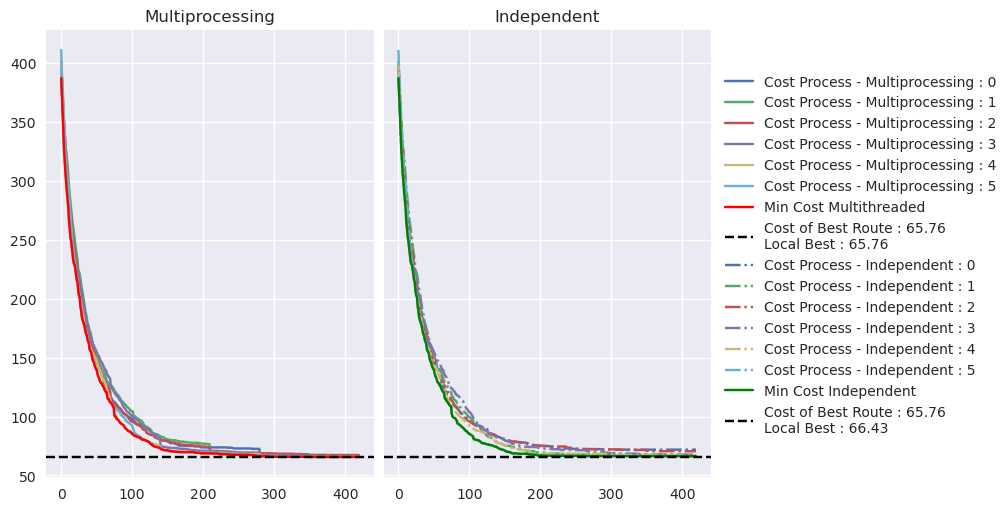

In [18]:
min_cost = min(min_multi_cost_df["Cost"].iloc[-1], min_independent_cost_df["Cost"].iloc[-1])
name_best = ["Multiprocess", "Indipendent"][np.argmin([min_multi_cost_df["Cost"].iloc[-1], min_independent_cost_df["Cost"].iloc[-1]])]
local_min_cost = min_multi_cost_df["Cost"].iloc[-1], min_independent_cost_df["Cost"].iloc[-1]


fig, axs = plt.subplots(1,2,figsize = (10, 5),sharex=True, sharey=True, layout='constrained')

for idx, df in enumerate(multiprocess_cost_dfs):
    axs[0].plot(df["Cost"], label=f"Cost Process - Multiprocessing : {idx}")

for idx, df in enumerate(independent_cost_dfs):
    axs[1].plot(
        df["Cost"],
        linestyle="-.",
        label=f"Cost Process - Independent : {idx}",
    )

axs[0].plot(min_multi_cost_df["Cost"], label="Min Cost Multithreaded", color="red")
axs[1].plot(
    min_independent_cost_df["Cost"], label="Min Cost Independent", color="green"
)
for ax, cost in zip(axs, local_min_cost):
    ax.axhline(
    min_cost, color="black", linestyle="--", label=f"Cost of Best Route : {min_cost:.2f}\nLocal Best : {cost:.2f}"
    )
axs[0].set_title("Multiprocessing")
axs[1].set_title("Independent")

fig.legend(loc='outside center right')

At least with my implementation there isn't a significant difference in the final results or convergence rate. The advantage of using multiprocessing it seems to be that all populations seem to converge to a common solution, while in the indipendent case this does not happen.

An improvement in the code could be to use during crossover an untangler function to avoid the creation of invalid routes. This will increase the convergence speed of both independent and multiprocessed algorithm.
Other exchange mechanism could be improve the convergence ratio.

In [8]:
cities = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data['LONGITUDE'], data['LATITUDE']), crs="EPSG:4326")
cities


,INDEX,PROVINCE,LONGITUDE,LATITUDE,geometry
0,0,Agrigento,13.57470,37.3123,POINT (13.5747 37.3123)
1,65,Palermo,13.35240,38.1112,POINT (13.3524 38.1112)
2,97,Trapani,12.51600,38.0174,POINT (12.516 38.0174)
3,96,Ogliastra,9.66781,39.9705,POINT (9.66781 39.9705)
4,61,Nuoro,9.34238,40.1277,POINT (9.34238 40.1277)
...,...,...,...,...,...
106,90,Siracusa,15.29070,37.0646,POINT (15.2907 37.0646)
107,77,Ragusa,14.72130,36.9220,POINT (14.7213 36.922)
108,31,Enna,14.28070,37.5668,POINT (14.2807 37.5668)
109,19,Caltanissetta,14.06320,37.4899,POINT (14.0632 37.4899)


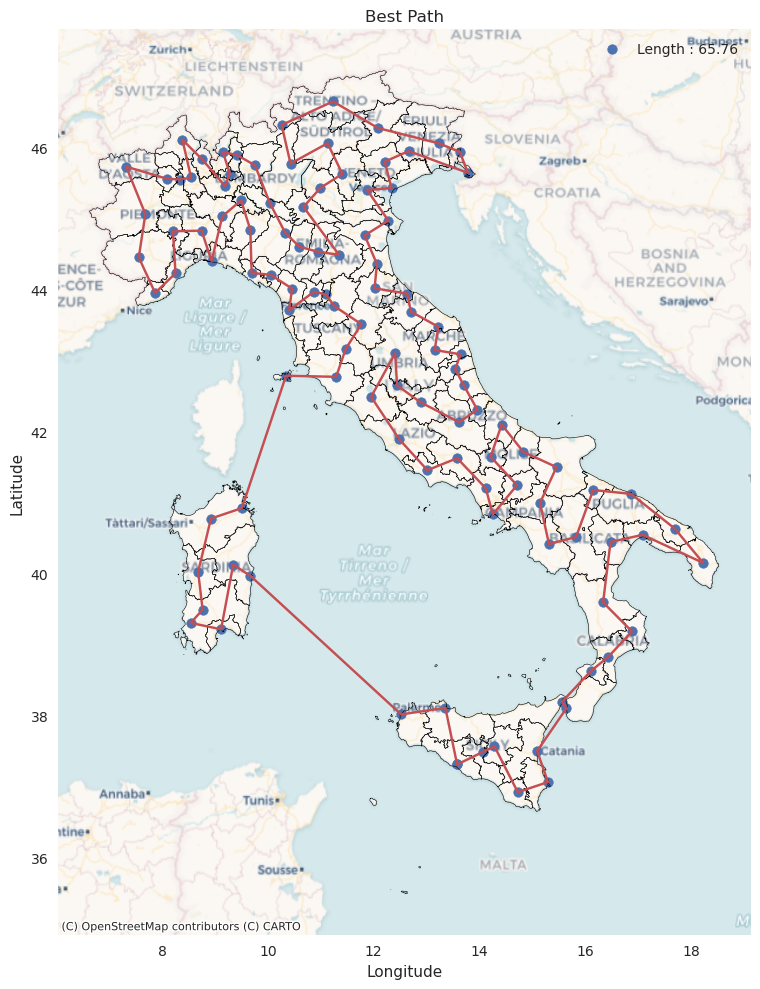

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

italy.boundary.plot(ax=ax, edgecolor='k', linewidth=0.4)
cities.plot(ax =ax, label = f'Length : {min_cost:.2f}')
cx.add_basemap(ax, crs=italy.crs.to_string(), source=xyz.CartoDB.Voyager)

plt.plot(data['LONGITUDE'], data['LATITUDE'], c='C2', marker = '.', markersize=.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Best Path')
plt.grid()
plt.legend()
plt.tight_layout()

In [10]:
point_data = pd.read_csv("eser_10/results/multi_thread/best_route.csv").set_index('INDEX')
point_data.sort_index(inplace=True)
point_data


,PROVINCE,LONGITUDE,LATITUDE
INDEX,,,
0,Agrigento,13.57470,37.3123
1,Alessandria,8.74503,44.8350
2,Ancona,13.21880,43.4801
3,Aosta,7.31966,45.7371
4,Arezzo,11.76390,43.5171
...,...,...,...
105,Vercelli,8.34628,45.5554
106,Verona,10.99240,45.4385
107,Vibo Valentia,16.09870,38.6267


In [11]:
%%time
list(map(int, min_multi_cost_df.loc[0, 'Sequence'].split()))


CPU times: user 651 μs, sys: 103 μs, total: 754 μs
Wall time: 740 μs


[0,
 19,
 25,
 62,
 16,
 68,
 100,
 74,
 1,
 80,
 29,
 20,
 46,
 107,
 27,
 93,
 4,
 31,
 9,
 42,
 23,
 17,
 108,
 99,
 102,
 66,
 3,
 30,
 95,
 77,
 13,
 50,
 78,
 35,
 81,
 92,
 21,
 59,
 2,
 22,
 103,
 5,
 94,
 65,
 90,
 70,
 11,
 101,
 57,
 45,
 64,
 71,
 56,
 85,
 79,
 87,
 44,
 55,
 37,
 7,
 28,
 84,
 83,
 82,
 88,
 26,
 58,
 6,
 51,
 36,
 106,
 67,
 73,
 91,
 12,
 86,
 109,
 39,
 10,
 52,
 24,
 8,
 18,
 32,
 34,
 47,
 104,
 15,
 69,
 76,
 75,
 89,
 49,
 63,
 41,
 53,
 60,
 105,
 38,
 72,
 40,
 97,
 48,
 33,
 98,
 43,
 96,
 61,
 14,
 54]

In [12]:
%%time

np.fromstring(min_multi_cost_df.loc[0, 'Sequence'], dtype=np.int32, sep=' ')

CPU times: user 3.51 ms, sys: 550 μs, total: 4.06 ms
Wall time: 22.1 ms


array([  0,  19,  25,  62,  16,  68, 100,  74,   1,  80,  29,  20,  46,
       107,  27,  93,   4,  31,   9,  42,  23,  17, 108,  99, 102,  66,
         3,  30,  95,  77,  13,  50,  78,  35,  81,  92,  21,  59,   2,
        22, 103,   5,  94,  65,  90,  70,  11, 101,  57,  45,  64,  71,
        56,  85,  79,  87,  44,  55,  37,   7,  28,  84,  83,  82,  88,
        26,  58,   6,  51,  36, 106,  67,  73,  91,  12,  86, 109,  39,
        10,  52,  24,   8,  18,  32,  34,  47, 104,  15,  69,  76,  75,
        89,  49,  63,  41,  53,  60, 105,  38,  72,  40,  97,  48,  33,
        98,  43,  96,  61,  14,  54], dtype=int32)

MovieWriter ffmpeg unavailable; using Pillow instead.


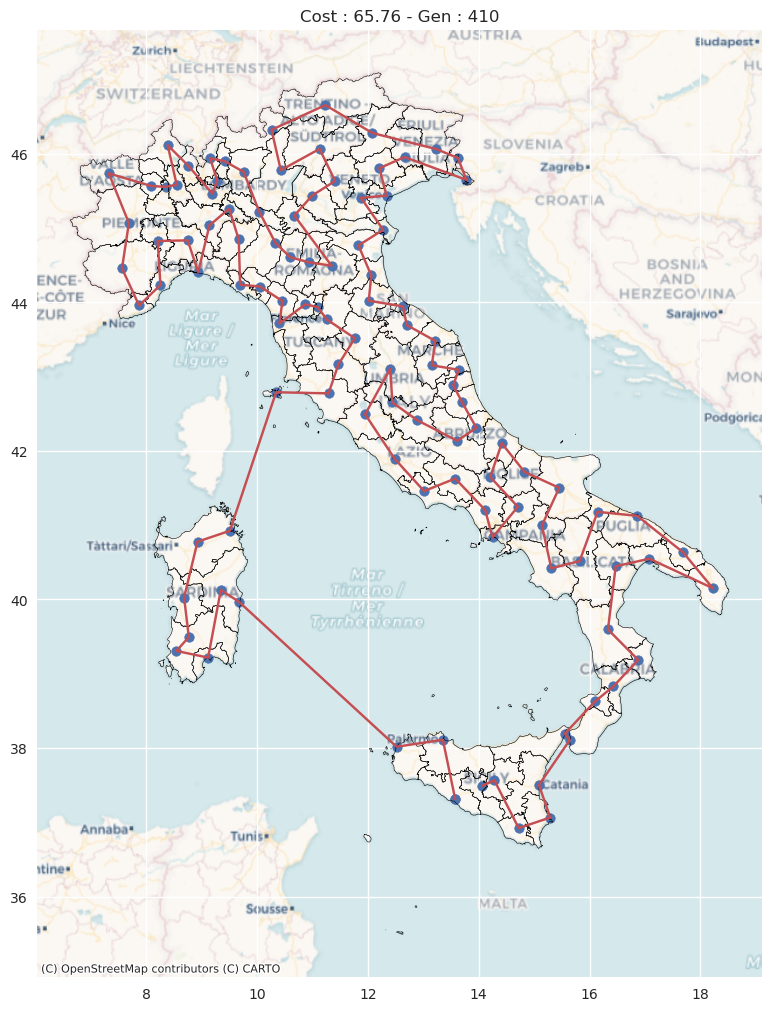

In [13]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10), layout='constrained')

italy.boundary.plot(ax=ax, edgecolor='k', linewidth=0.4)
cities.plot(ax =ax, label = f'Length : {min_cost:.2f}')
cx.add_basemap(ax, crs=italy.crs.to_string(), source=xyz.CartoDB.Voyager)

line, = ax.plot([], [], c='C2', marker = 'none')
title = ax.set_title('')

def update(frame):
    sequence = list(map(int, min_multi_cost_df.loc[frame, 'Sequence'].split()))
    latitude = point_data.loc[sequence, 'LATITUDE']
    longitude = point_data.loc[sequence, 'LONGITUDE']
    line.set_data(longitude, latitude)
    title.set_text(f'Cost : {min_multi_cost_df.loc[frame, "Cost"]:.2f} - Gen : {frame}')
    return line, title,

ani = FuncAnimation(fig, update, frames=range(0, min_multi_cost_df.shape[0], 10), interval=1000, blit=True)
ani.save('images/best_route.gif',  fps=10)

![nuovo](./images/best_route.gif)